In [1]:
#import analysis
import similarity_analysis as analysis
from importlib import reload
reload(analysis)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List

# Create a new folder to store the plots
os.makedirs(analysis.PLOT_OUTPUT_FOLDER, exist_ok=True)
file_path = "data/cross_tuning_full_scores.csv"

## Plots for variability analysis

You need the file `data/cross_tuning_scores_full_scores.csv' to run this notebook.

#### Paper Figures

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def load_data(path: str) -> pd.DataFrame:
    """Load data from CSV into DataFrame."""
    return pd.read_csv(path, index_col=0)


def separate_scores(df: pd.DataFrame) -> (pd.Series, pd.DataFrame):
    """Separate MMLU scores from bias scores."""
    mmlu = df.loc['MMLU']
    biases = df.drop('MMLU')
    return mmlu, biases


def compute_model_stats(df: pd.DataFrame, model_cols: list) -> dict:
    """Compute mean and std across bias means and MMLU scores for given model columns."""
    mmlu_scores, biases = separate_scores(df[model_cols])
    # Biases
    bias_means = biases.mean(axis=1)
    bias_mean_of_means = bias_means.mean()
    #bias_std_of_means = bias_means.std(ddof=1)
    bias_mean_of_stds = biases.std(axis=1).mean()
    
    # MMLU
    #mmlu_scores = mmlu_scores * 100 # scale to 0-100 (MMLU is originally 0-100, but these scores were scaled to 0-1)
    mmlu_mean = mmlu_scores.mean()
    mmlu_std = mmlu_scores.std(ddof=1)

    
    return {
        'Bias Mean': bias_mean_of_means,
        #'Bias Std': bias_std_of_means, # This is the standard deviation of the biases (after averaging over the seeds)
        'Bias Std': bias_mean_of_stds, # This is the mean of the standard deviations of the biases (over the seeds)
        'MMLU Mean': mmlu_mean,
        'MMLU Std': mmlu_std
    }

def compute_variabilities(df: pd.DataFrame, include_originals: bool = True) -> pd.DataFrame:
    """Compute means and standard deviations for biases and MMLU scores."""
    seed_models = ['T5-Flan', 'T5-Tulu', 'OLMo-Flan', 'OLMo-Tulu']
    results = []

    for model in seed_models:
        model_cols = [col for col in df.columns if col.startswith(model)]
        if len(model_cols) < 2:
            continue

        stats = compute_model_stats(df, model_cols)
        stats['Model'] = model
        results.append(stats)

    if include_originals:
        for original in ['Flan-T5', 'OLMo-SFT']:
            stats = compute_model_stats(df, [original])
            stats['Model'] = original
            results.append(stats)

    ordered_models = ['T5-Flan', 'Flan-T5', 'T5-Tulu', 'OLMo-Tulu', 'OLMo-Flan', 'OLMo-SFT']
    results_df = pd.DataFrame(results).set_index('Model')

    # Using .loc to ensure exact selection and avoid NA issues clearly
    results_df = results_df.loc[results_df.index.intersection(ordered_models)].reset_index()

    return results_df



# Plotting functions for modularity and clarity
def plot_bar_variability(df: pd.DataFrame):
    """Plot bar plot for standard deviations of seeds, omitting original models."""
    df_bar = df[~df['Model'].isin(['OLMo-SFT', 'Flan-T5'])]
    x = np.arange(len(df_bar))
    width = 0.35

    plt.rcParams.update({'font.size': 22})
    plt.figure(figsize=(10, 6))
    bias_color = 'mediumpurple' #'navajowhite' #'#228B22' # soft pastel dark green
    mmlu_color = '#696969' # soft pastel dark grey
    plt.bar(x - width/2, df_bar['Bias Std'], width, color=bias_color, label='Bias Std')
    plt.bar(x + width/2, df_bar['MMLU Std'], width, color=mmlu_color, label='MMLU Std')

    plt.xticks(x, df_bar['Model'])
    plt.ylabel('Mean Standard Deviation')
    plt.title('Variability Across Random Seeds')
    plt.legend(loc='upper right', fontsize=20)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'./plots/randomness_analysis/bar_variability_plot.pdf')
    plt.show()


def plot_scatter_variability(df: pd.DataFrame):
    """Scatter plot clearly showing means and std deviations for each model, including originals."""
    x = np.arange(len(df))
    plt.figure(figsize=(10, 6))

    plt.errorbar(x, df['Bias Mean'], yerr=df['Bias Std'], fmt='o', color='coral', label='Biases', capsize=5)
    plt.errorbar(x, df['MMLU Mean'], yerr=df['MMLU Std'], fmt='o', color='mediumseagreen', label='MMLU', capsize=5)

    plt.xticks(x, df['Model'], rotation=45)
    plt.ylabel('Mean Scores (with Std Dev)')
    plt.title('Mean and Variability per Model (Including Originals)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'./plots/randomness_analysis/scatter_variability_plot.pdf')
    plt.show()



def plot_scatter_all_biases(df: pd.DataFrame, original_df: pd.DataFrame):
    """Scatter plot showing individual biases for seed and original models."""
    biases = original_df.index.drop('MMLU')
    colors = sns.color_palette('husl', len(biases))

    plt.figure(figsize=(8, 16))

    model_order = ['T5-Flan', 'Flan-T5', 'OLMo-Tulu', 'OLMo-SFT']

    for idx, model in enumerate(model_order):
        if model in ['OLMo-SFT', 'Flan-T5']:
            values = original_df[model]
        else:
            seed_cols = original_df.columns[original_df.columns.str.startswith(model)]
            seed_means = original_df[seed_cols].mean(axis=1)
            seed_std = original_df[seed_cols].std(axis=1)
            seed_means.name = model

        for i, bias in enumerate(biases):
            if model in ['OLMo-SFT', 'Flan-T5']:
                plt.scatter(model, original_df.loc[bias, model], color=colors[i], alpha=0.7, label=bias if model == 'T5-Flan' else None)
            else:
                plt.scatter(model, seed_means[bias], color=colors[i], alpha=0.7, label=bias if model == 'T5-Flan' else None)

    plt.ylabel('Mean Bias Scores')
    plt.title('Bias Means across Seeds and Original Models')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'./plots/randomness_analysis/scatter_all_biases_plot.pdf')
    plt.show()

variabilities_df.columns = Index(['Model', 'Bias Mean', 'Bias Std', 'MMLU Mean', 'MMLU Std'], dtype='object')
variabilities_df.index = RangeIndex(start=0, stop=6, step=1)


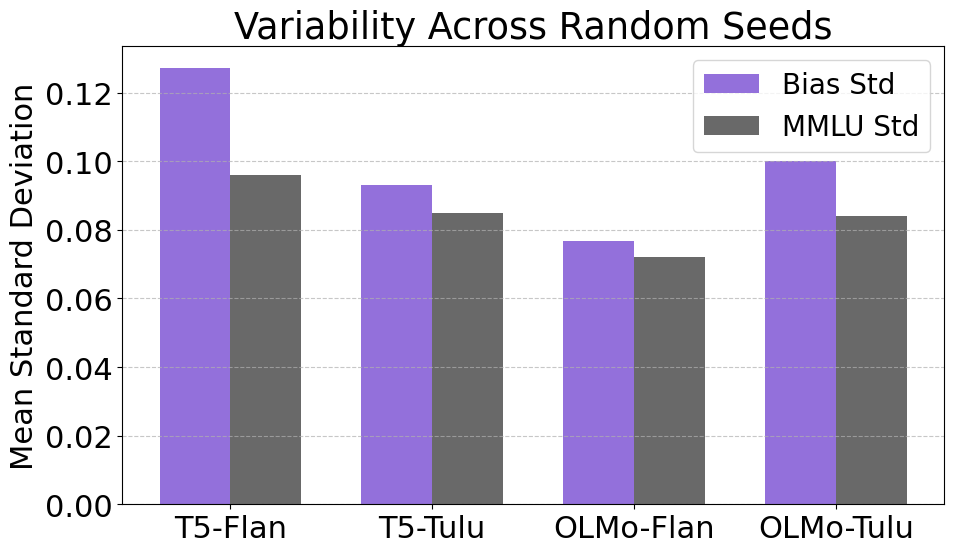

In [9]:
def main(file_path: str, option: str = 'scatter'):
    df = load_data(file_path)
    variabilities_df = compute_variabilities(df, include_originals=True)

    # Fix MMLU Std for T5-Flan manually   
    print(f"variabilities_df.columns = {variabilities_df.columns}")
    print(f"variabilities_df.index = {variabilities_df.index}")
    
    # variabilities_df.columns = Index(['Model', 'Bias Mean', 'Bias Std', 'MMLU Mean', 'MMLU Std'], dtype='object')
    # Change the MMLU Std for T5-Flan manually 
    # Update MMLU Std values using boolean indexing
    # These std were taken from the resutls in open-instruct MMLU scores
    variabilities_df.loc[variabilities_df['Model'] == 'T5-Flan', 'MMLU Std'] = 0.096
    variabilities_df.loc[variabilities_df['Model'] == 'T5-Tulu', 'MMLU Std'] = 0.085
    variabilities_df.loc[variabilities_df['Model'] == 'OLMo-Tulu', 'MMLU Std'] = 0.084
    variabilities_df.loc[variabilities_df['Model'] == 'OLMo-Flan', 'MMLU Std'] = 0.072

    if option == 'bar':
        plot_bar_variability(variabilities_df)
    elif option == 'scatter':
        plot_scatter_variability(variabilities_df)
    elif option == 'scatter_all_biases':
        plot_scatter_all_biases(variabilities_df, df)


option='bar'
main(file_path,option=option)
#option='scatter_all_biases'
#main(file_path,option=option)
#option='bar'
#main(file_path,option=option)    

#### Print Latex Table full Results

In [10]:
import pandas as pd

def generate_latex_table(df: pd.DataFrame, model_prefix: str, table_label: str, full_ft_col: str) -> str:
    """
    Generate a LaTeX table for models with a specific prefix.
    
    Parameters:
    - df: DataFrame containing the bias scores.
    - model_prefix: The prefix of the models to include in the table (e.g., 'OLMo' or 'T5').
    - table_label: The label for the LaTeX table.
    - full_ft_col: The column name for the full fine-tuned model.
    
    Returns:
    - A string containing the LaTeX table.
    """
    # Filter columns based on the model prefix and exclude the full fine-tuned model
    tulu_seed_columns = [col for col in df.columns if col.startswith(model_prefix) and 'Tulu-Seed' in col]
    flan_seed_columns = [col for col in df.columns if col.startswith(model_prefix) and 'Flan-Seed' in col]
    
    # Calculate means and standard deviations for Tulu and Flan seed models
    df['Mean_Tulu'] = df[tulu_seed_columns].mean(axis=1)
    df['Std_Tulu'] = df[tulu_seed_columns].std(axis=1)
    df['Mean_Flan'] = df[flan_seed_columns].mean(axis=1)
    df['Std_Flan'] = df[flan_seed_columns].std(axis=1)
    
    # Start building the LaTeX table
    latex_table = f"""
\\begin{{table}}[htbp]
    \\centering
    \\caption{{Bias scores for {model_prefix} models across three random seeds (1–3), with their mean and standard deviation, and original fine-tuned results.}}
    \\label{{tab:{table_label}}}
    \\renewcommand{{\\arraystretch}}{{1.2}}
    \\footnotesize
    \\begin{{adjustbox}}{{max width=\\textwidth}}
    \\begin{{tabular}}{{l|rrrrrr|r@{{\\hskip 6pt}}rrrrr}}
        \\toprule
    """
    
    if model_prefix == "OLMo":
        latex_table += (
            f"        & \\multicolumn{{6}}{{c}}{{\\textbf{{{model_prefix}-Tulu}}}} & \\multicolumn{{5}}{{c}}{{\\textbf{{{model_prefix}-Flan}}}} \\\\\n"
            f"        \\cmidrule(lr){{2-7}} \\cmidrule(lr){{8-12}}\n"
            f"        \\textbf{{Bias}} & 1 & 2 & 3 & Mean & Std & Org & 1 & 2 & 3 & Mean & Std \\\\\n"
        )
    else:  # T5
        latex_table += (
            f"        & \\multicolumn{{6}}{{c}}{{\\textbf{{{model_prefix}-Flan}}}} & \\multicolumn{{5}}{{c}}{{\\textbf{{{model_prefix}-Tulu}}}} \\\\\n"
            f"        \\cmidrule(lr){{2-7}} \\cmidrule(lr){{8-12}}\n"
            f"        \\textbf{{Bias}} & 1 & 2 & 3 & Mean & Std & Org & 1 & 2 & 3 & Mean & Std \\\\\n"
        )
    
    latex_table += "        \\midrule\n"
    
    # Add rows for each bias
    for bias in df.index:
        # Replace specific bias names
        display_bias = bias.replace("Escalation of Commitment", "Escalation of C.").replace("Fundamental Attribution Error", "Fundamental A.E")
        if model_prefix == "OLMo":
            row = (
                f"        {display_bias} & "
                + " & ".join(f"{df.at[bias, col]:.2f}" for col in tulu_seed_columns)
                + f" & {df.at[bias, 'Mean_Tulu']:.2f} & {df.at[bias, 'Std_Tulu']:.2f} & {df.at[bias, full_ft_col]:.2f} & "
                + " & ".join(f"{df.at[bias, col]:.2f}" for col in flan_seed_columns)
                + f" & {df.at[bias, 'Mean_Flan']:.2f} & {df.at[bias, 'Std_Flan']:.2f} \\\\\n"
            )
        else:  # T5
            row = (
                f"        {display_bias} & "
                + " & ".join(f"{df.at[bias, col]:.2f}" for col in flan_seed_columns)
                + f" & {df.at[bias, 'Mean_Flan']:.2f} & {df.at[bias, 'Std_Flan']:.2f} & {df.at[bias, full_ft_col]:.2f} & "
                + " & ".join(f"{df.at[bias, col]:.2f}" for col in tulu_seed_columns)
                + f" & {df.at[bias, 'Mean_Tulu']:.2f} & {df.at[bias, 'Std_Tulu']:.2f} \\\\\n"
            )
        latex_table += row
    
    # Close the LaTeX table
    latex_table += """
        \\bottomrule
    \\end{tabular}
    \\end{adjustbox}
\\end{table}
"""
    return latex_table

def print_full_results_latex_table():
    # Load data directly from the CSV file
    file_path = "data/cross_tuning_full_scores.csv"
    df = pd.read_csv(file_path, index_col=0)
    
    # Generate LaTeX tables for OLMo and T5 models
    olmo_table = generate_latex_table(df, "OLMo", "olmo_bias_scores", "OLMo-SFT")
    t5_table = generate_latex_table(df, "T5", "t5_bias_scores", "Flan-T5")
    
    # Print the LaTeX tables
    print(olmo_table)
    print(t5_table)

print_full_results_latex_table()


\begin{table}[htbp]
    \centering
    \caption{Bias scores for OLMo models across three random seeds (1–3), with their mean and standard deviation, and original fine-tuned results.}
    \label{tab:olmo_bias_scores}
    \renewcommand{\arraystretch}{1.2}
    \footnotesize
    \begin{adjustbox}{max width=\textwidth}
    \begin{tabular}{l|rrrrrr|r@{\hskip 6pt}rrrrr}
        \toprule
            & \multicolumn{6}{c}{\textbf{OLMo-Tulu}} & \multicolumn{5}{c}{\textbf{OLMo-Flan}} \\
        \cmidrule(lr){2-7} \cmidrule(lr){8-12}
        \textbf{Bias} & 1 & 2 & 3 & Mean & Std & Org & 1 & 2 & 3 & Mean & Std \\
        \midrule
        Anchoring & 0.14 & -0.03 & 0.02 & 0.04 & 0.09 & 0.06 & 0.13 & 0.09 & 0.02 & 0.08 & 0.05 \\
        Anthropomorphism & -0.03 & -0.04 & -0.08 & -0.05 & 0.03 & -0.07 & -0.12 & -0.03 & -0.05 & -0.07 & 0.05 \\
        Availability Heuristic & 0.10 & 0.29 & 0.18 & 0.19 & 0.09 & 0.14 & 0.14 & -0.00 & 0.04 & 0.06 & 0.07 \\
        Bandwagon Effect & 0.02 & 0.27 & -0.02 & 

## Loyalty Analysis across seeds

Calculating aggregations for df.index = Index(['Anchoring', 'Anthropomorphism', 'Availability Heuristic',
       'Bandwagon Effect', 'Confirmation Bias', 'Conservatism',
       'Disposition Effect', 'Endowment Effect', 'Escalation of Commitment',
       'Framing Effect', 'Fundamental Attribution Error', 'Halo Effect',
       'Hindsight Bias', 'Hyperbolic Discounting', 'Illusion of Control',
       'In-Group Bias', 'Information Bias', 'Loss Aversion',
       'Mental Accounting', 'Negativity Bias', 'Not Invented Here',
       'Optimism Bias', 'Planning Fallacy', 'Reactance', 'Risk Compensation',
       'Self-Serving Bias', 'Social Desirability Bias', 'Status-Quo Bias',
       'Stereotyping', 'Survivorship Bias', 'Certainty', 'Belief Valid'],
      dtype='object', name='bias')


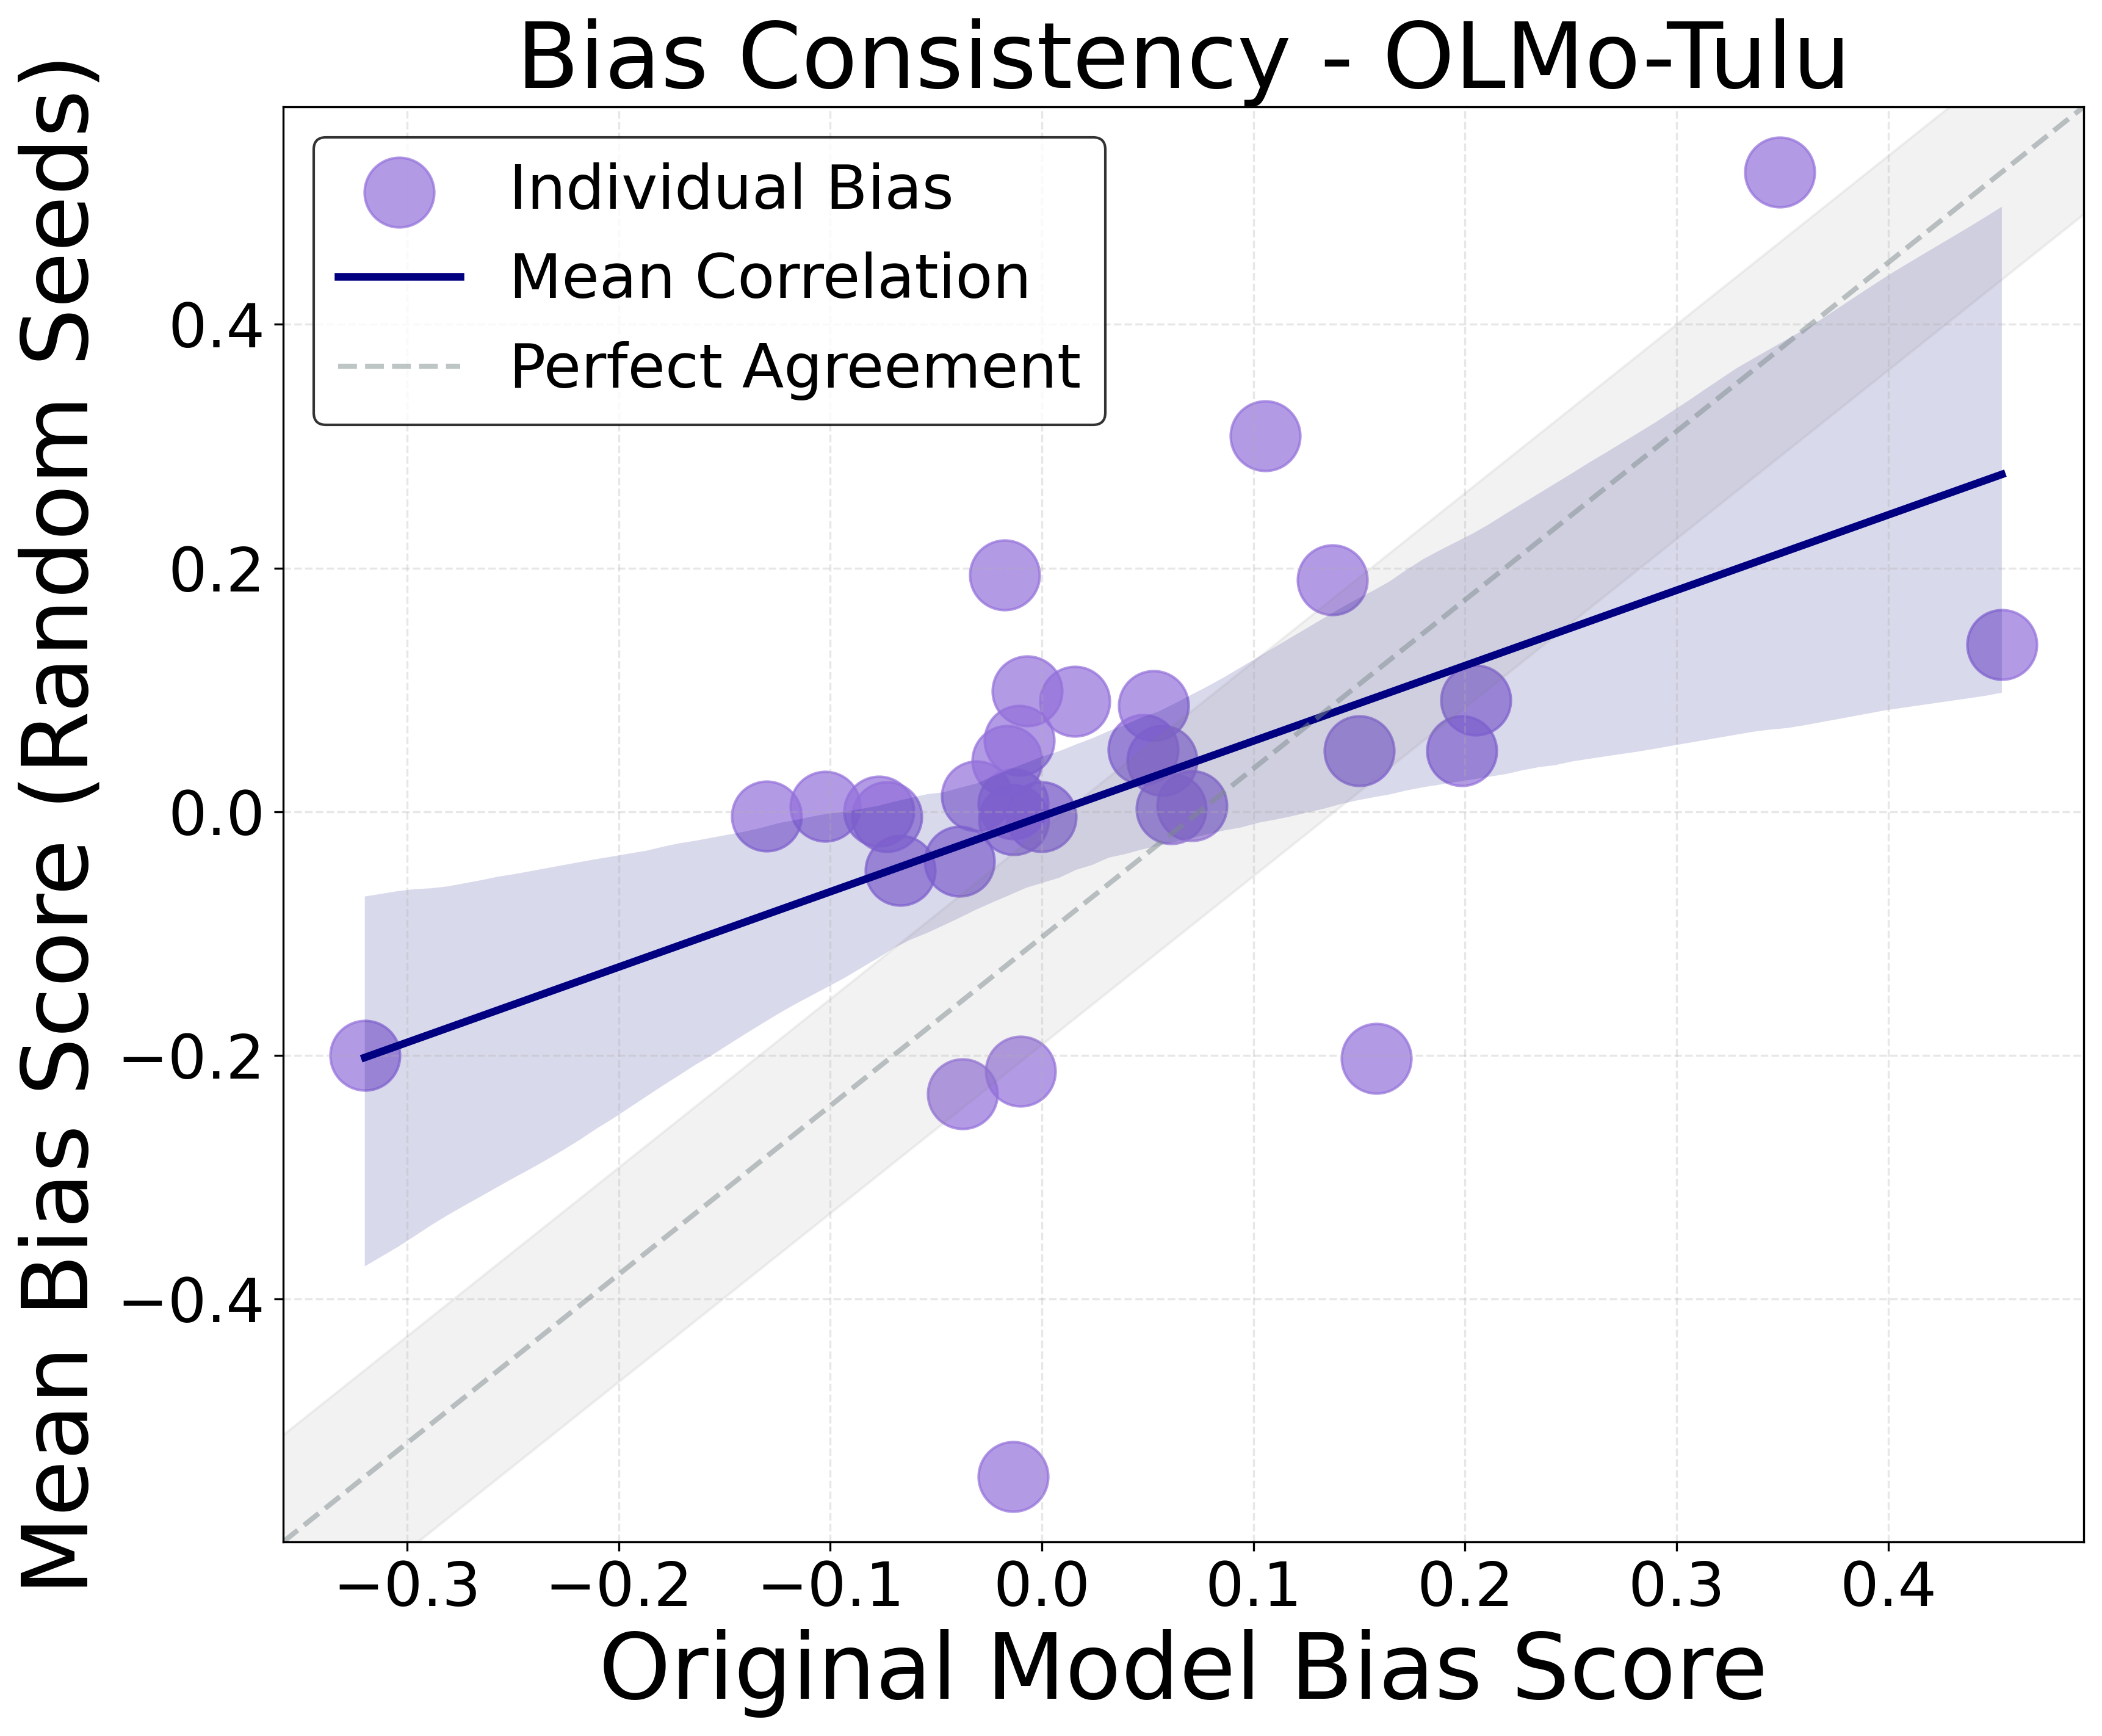

Calculating aggregations for df.index = Index(['Anchoring', 'Anthropomorphism', 'Availability Heuristic',
       'Bandwagon Effect', 'Confirmation Bias', 'Conservatism',
       'Disposition Effect', 'Endowment Effect', 'Escalation of Commitment',
       'Framing Effect', 'Fundamental Attribution Error', 'Halo Effect',
       'Hindsight Bias', 'Hyperbolic Discounting', 'Illusion of Control',
       'In-Group Bias', 'Information Bias', 'Loss Aversion',
       'Mental Accounting', 'Negativity Bias', 'Not Invented Here',
       'Optimism Bias', 'Planning Fallacy', 'Reactance', 'Risk Compensation',
       'Self-Serving Bias', 'Social Desirability Bias', 'Status-Quo Bias',
       'Stereotyping', 'Survivorship Bias', 'Certainty', 'Belief Valid'],
      dtype='object', name='bias')


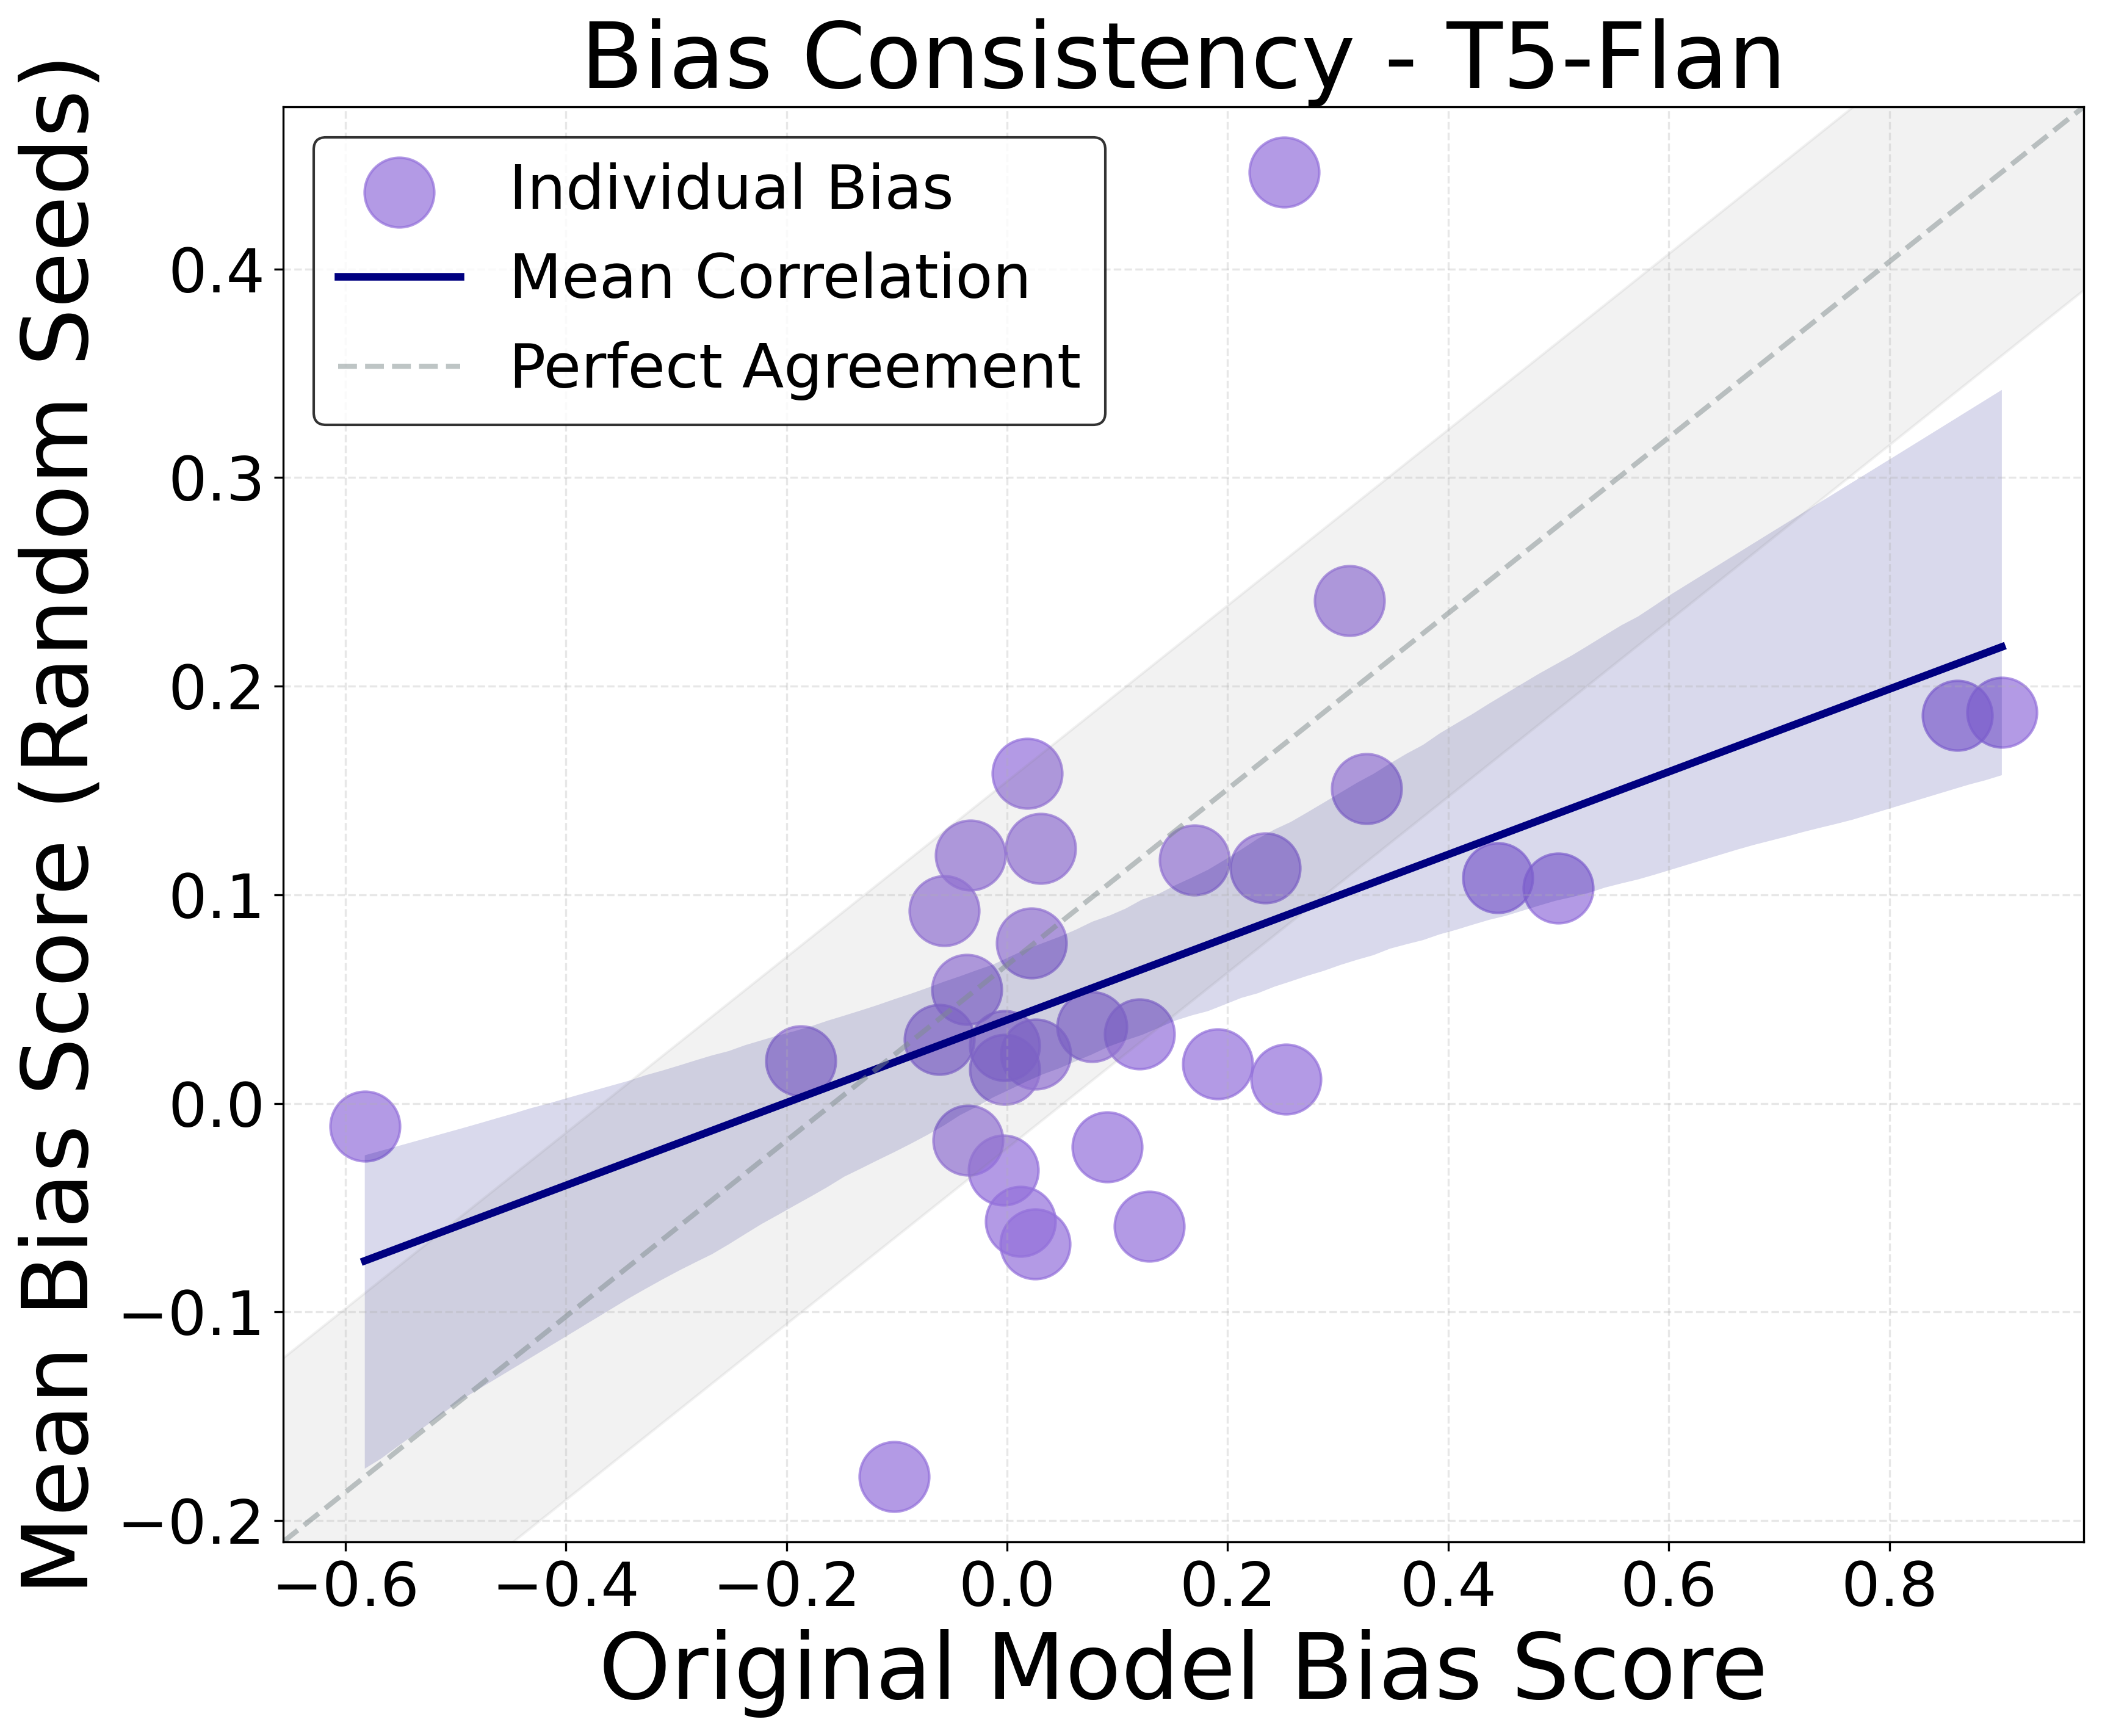

\begin{table}[htbp]
\centering
\begin{tabular}{l|ccccc|ccccc}
\setlength{\tabcolsep}{6pt} % Adjust column spacing 
\ \renewcommand{\arraystretch}{1.2} % Adjust row spacing 
\ & \multicolumn{5}{c|}{OLMo-Tulu} & \multicolumn{5}{c}{T5-Flan} \\
Bias Measure & Original & Mean & Median & Majority & Agg Similarity & Original & Mean & Median & Majority & Agg Similarity \\
\hline
Anchoring & 0.06 & 0.04 & 0.02 & True & True & 0.33 & 0.15 & 0.16 & True & True \\
Anthropomorphism & -0.07 & -0.05 & -0.04 & True & True & -0.19 & 0.02 & 0.05 & False & False \\
Availability Heuristic & 0.14 & 0.19 & 0.18 & True & True & 0.03 & 0.02 & 0.05 & True & True \\
Bandwagon Effect & 0.02 & 0.09 & 0.02 & True & True & 0.25 & 0.01 & 0.03 & False & False \\
Confirmation Bias & -0.02 & 0.04 & 0.03 & True & True & 0.03 & -0.07 & -0.08 & True & True \\
Conservatism & -0.01 & -0.01 & 0.00 & True & True & -0.04 & 0.05 & 0.08 & True & True \\
Disposition Effect & 0.05 & 0.05 & -0.03 & True & True & -0.58 & -0.01 & -0.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

THRESHOLD = 0.088  # adjustable threshold constant

def load_and_prepare_data(file_path: str) -> pd.DataFrame:
    """Load CSV and return a clean DataFrame."""
    df = pd.read_csv(file_path, index_col=0)

    #print(f"df.index = {df.index}")
    # remove the last row (MMLU)
    df = df.iloc[:-1]
    #print(f" Working with df.index = {df.index}")

    return df

def get_seed_and_original_columns(df: pd.DataFrame, original_model_name: str):
    """
    Identify columns for random seeds and the original model explicitly.

    Args:
        df (pd.DataFrame): Dataframe containing bias scores.
        original_model_name (str): Name of the original tuned model.

    Returns:
        seed_columns (list): List of column names for random seeds.
        original_col (str): Column name for the original model.
    """
    model_to_seeds = {
        'OLMo-SFT': ['OLMo-Tulu-Seed-0', 'OLMo-Tulu-Seed-1', 'OLMo-Tulu-Seed-2'],
        'Flan-T5': ['T5-Flan-Seed-0', 'T5-Flan-Seed-1', 'T5-Flan-Seed-2']
    }

    seed_columns = model_to_seeds.get(original_model_name, [])
    original_col = original_model_name

    return seed_columns, original_col


def categorize_score(score: float, threshold: float = THRESHOLD) -> str:
    """Categorize score into positive, neutral, or negative."""
    if score > threshold:
        return 'positive'
    elif score < -threshold:
        return 'negative'
    else:
        return 'neutral'

def majority_vote_agreement(seed_scores: np.ndarray, original_score: float, threshold: float = THRESHOLD) -> bool:
    """Determine if majority vote agrees with original score direction."""
    original_category = categorize_score(original_score, threshold)
    seed_categories = [categorize_score(s, threshold) for s in seed_scores]
    
    # Count occurrences
    category_counts = pd.Series(seed_categories).value_counts()
    
    # Check if any category has at least 2 votes
    if category_counts.max() >= 2:
        majority_category = category_counts.idxmax()
        return original_category == majority_category
    else:
        # No clear majority
        return False

def aggregate_seeds_similarity(mean_score: float, median_score: float, majority_agree: bool, original_score: float) -> bool:
    """Determine if the aggregate measures are similar to the original score."""
    return majority_agree or abs(mean_score - original_score) < THRESHOLD or abs(median_score - original_score) < THRESHOLD


def calculate_aggregations(df: pd.DataFrame, original_model_name: str):
    """Calculate mean, median, and majority vote agreement."""
    seed_cols, orig_col = get_seed_and_original_columns(df, original_model_name)

    results = []
    print(f"Calculating aggregations for df.index = {df.index}")
    for bias_measure in df.index:
        seed_scores = df.loc[bias_measure, seed_cols].values
        original_score = df.loc[bias_measure, orig_col]

        mean_score = np.mean(seed_scores)
        median_score = np.median(seed_scores)
        majority_agree = majority_vote_agreement(seed_scores, original_score)
        aggregate_similar = aggregate_seeds_similarity(mean_score, median_score, majority_agree, original_score)

        results.append({
            'Bias Measure': bias_measure,
            'Original': original_score,
            'Mean': mean_score,
            'Median': median_score,
            'Majority Agreement': majority_agree,
            'Aggregate Similarity': aggregate_similar
        })
    return pd.DataFrame(results)


def plot_scatter(results_df: pd.DataFrame, plot_mean: bool = True, plot_median: bool = True, plot_majority: bool = True):
    """Helper function to plot scatter plots for Mean and Median."""
    if plot_mean:
        sns.scatterplot(x='Original', y='Mean', data=results_df, label='Mean Bias Score', s=300)
    if plot_median:
        sns.scatterplot(x='Original', y='Median', data=results_df, label='Median Bias Score', s=300, marker='^')

    # Highlight mean where majority vote agrees
    agree_df = results_df[results_df['Majority Agreement']]
    if plot_majority and not agree_df.empty:
        plt.scatter(agree_df['Original'], agree_df['Mean'],
                    color='green', s=450, facecolors='none', edgecolors='green', linewidth=2,
                    label='Majority Vote Agree')

def plot_correlation(results_df: pd.DataFrame):
    """Helper function to plot correlation lines for Mean and Median."""
    # Add regression plots for Mean and Median
    sns.regplot(x='Original', y='Mean', data=results_df, scatter=False, color='blue', line_kws={"label": "Mean Regression"})
    sns.regplot(x='Original', y='Median', data=results_df, scatter=False, color='purple', line_kws={"label": "Median Regression"})
    sns.regplot(x='Original', y='Majority Agreement', data=results_df, scatter=False, color='green', line_kws={"label": "Majority Agreement Regression"})

def plot_diagonal_line(results_df: pd.DataFrame):
    """Plot the diagonal line."""
    # Get the range for the diagonal line
    x_min, x_max = results_df['Original'].min(), results_df['Original'].max()
    x = np.linspace(x_min, x_max, 100)
    
    # Plot the diagonal line
    plt.plot(x, x, 'k--', linewidth=1, label='Perfect Agreement')
    
    # Add shaded region representing THRESHOLD
    plt.fill_between(x, x - THRESHOLD, x + THRESHOLD, 
                    color='gray', alpha=0.2, 
                    #label=f'±{THRESHOLD:.2f} Threshold')
                    label=f'Agreement within {THRESHOLD:.2f}')

def plot_aggregations_comparison(results_df: pd.DataFrame, model_group: str, scatter_or_correlation: str, plot_mean: bool = True, plot_median: bool = True, plot_majority: bool = True):
    """Plot original vs. mean and median scores with majority vote agreement."""

    plt.figure(figsize=(12, 10))
    # font size of the plot
    plt.rcParams.update({'font.size': 30})
    if scatter_or_correlation == 'scatter':
        plot_scatter(results_df, plot_mean=plot_mean, plot_median=plot_median, plot_majority=plot_majority)
    else:
        plot_correlation(results_df)

    plot_diagonal_line(results_df)

    # Calculate correlations
    mean_correlation = results_df['Original'].corr(results_df['Mean'])
    median_correlation = results_df['Original'].corr(results_df['Median'])
    #majority_correlation = results_df['Original'].corr(results_df['Majority Agreement'])

    # Plot correlation annotations
    if plot_mean:
        plt.annotate(f'Mean Correlation: {mean_correlation:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=30, color='blue')
    if plot_median:
        plt.annotate(f'Median Correlation: {median_correlation:.2f}', xy=(0.05, 0.90), xycoords='axes fraction', fontsize=30, color='orange')
    # if plot_majority:
    #     plt.annotate(f'Majority Agreement Correlation: {majority_correlation:.2f}', xy=(0.05, 0.85), xycoords='axes fraction', fontsize=30, color='green')

    
    plt.xlabel('Original Finetuned Model Bias Score')   
    plt.ylabel('Aggregated Seeds Bias Score')
    plt.title(f'{model_group}', fontsize=36)
    #plt.legend()
    # Make legend smaller
    plt.legend(loc='lower right', fontsize=20)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    # save the plot to a pdf file
    plt.savefig(f'./plots/randomness_analysis/aggregated_bias_scores_vs_original_{model_group}_{scatter_or_correlation}.pdf')
    plt.show()

def create_bias_comparison_plot(
    results_df: pd.DataFrame,
    model_group: str,
    figsize: tuple = (10, 6),
    font_scale: float = 1.2,
    save_plot: bool = True,
    output_dir: str = './plots/randomness_analysis'
) -> None:
    """
    Creates a professional scatter plot comparing original model bias scores with mean scores across random seeds.
    """
    # Set style to default
    plt.style.use('default')

    # Set font size
    plt.rcParams.update({'font.size': 24})
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize, dpi=300)
    
    def plot_scatter_and_correlation():
        """Plot scatter points and correlation line."""
        correlation = results_df['Original'].corr(results_df['Mean'])
        
        # First plot all points in blue
        for i, (_, row) in enumerate(results_df.iterrows()):
            ax.scatter(
                row['Original'],
                row['Mean'],
                s=750,
                color='mediumpurple', #'#228B22', #'#2E86C1',  # Blue
                alpha=0.7,
                label='Individual Bias' if i == 0 else ""  # Label only first occurrence
            )
        
        # Then add green circles around points with majority agreement
        # agree_df = results_df[results_df['Majority Agreement']]
        # if not agree_df.empty:
        #     ax.scatter(
        #         agree_df['Original'],
        #         agree_df['Mean'],
        #         s=450,  # Slightly larger to create circle effect
        #         facecolors='none',
        #         edgecolors='green',
        #         linewidth=2,
        #         label='Majority Agreement',
        #         alpha=0.7
        #     )
        
        # Add correlation line
        sns.regplot(
            data=results_df,
            x='Original',
            y='Mean',
            scatter=False,
            #color='#E74C3C',
            color= '#000080', # stronger green to match the scatter points
            line_kws={'linestyle': '-', 'linewidth': 3},
            ax=ax,
            label='Mean Correlation'
        )
        
        return correlation
    
    def add_diagonal_reference():
        """Add diagonal reference line and threshold region."""
        # Calculate axis limits based on data
        #x_min = min(results_df['Original'].min(), results_df['Mean'].min())
        #x_max = max(results_df['Original'].max(), results_df['Mean'].max())
        x_min = results_df['Original'].min()
        x_max = results_df['Original'].max()
        y_min = results_df['Mean'].min()
        y_max = results_df['Mean'].max()
        
        # Add some padding
        x_padding = (x_max - x_min) * 0.05
        y_padding = (y_max - y_min) * 0.05
        #limits = [x_min - padding, x_max + padding]
        x_limits = [x_min - x_padding, x_max + x_padding]
        y_limits = [y_min - y_padding, y_max + y_padding]
        # Set axis limits
        ax.set_xlim(x_limits)
        ax.set_ylim(y_limits)
        
        # Plot diagonal reference line
        ax.plot(
            x_limits,
            y_limits,
            '--',
            color='#7F8C8D',
            linewidth=2,
            alpha=0.5,
            label='Perfect Agreement'
        )
        
        # Add threshold region
        threshold = 0.088
        ax.fill_between(
            x_limits,
            [y - threshold for y in y_limits],
            [y + threshold for y in y_limits],
            color='gray',
            alpha=0.1,
            #label=f'±{threshold:.2f} Threshold'
        )
    
    def customize_plot(correlation: float):
        """Customize plot appearance."""
        ax.set_xlabel('Original Model Bias Score', fontsize=36)
        ax.set_ylabel('Mean Bias Score (Random Seeds)', fontsize=36)
        ax.set_title(
            f'Bias Consistency - {model_group}',
            fontsize=36,
        )
        
        # Customize grid
        ax.grid(True, linestyle='--', alpha=0.3)
        
        # Add simplified legend with black edge
        legend = ax.legend(
            loc='upper left',
            fontsize=24,
            frameon=True,
            facecolor='white',
            edgecolor='black',  # Added black edge
            ncol=1
        )
        
        plt.tight_layout()
    
    # Execute plotting functions
    correlation = plot_scatter_and_correlation()
    add_diagonal_reference()
    customize_plot(correlation)
    
    # Save plot if requested
    if save_plot:
        os.makedirs(output_dir, exist_ok=True)
        filename = f'bias_comparison_{model_group.lower().replace("-", "_")}.pdf'
        plt.savefig(
            os.path.join(output_dir, filename),
            bbox_inches='tight',
            dpi=300
        )
    
    plt.show()
    plt.close()


def results_to_latex_table(results_df_olmo: pd.DataFrame, results_df_t5: pd.DataFrame) -> str:
    """Output results as a LaTeX table."""
    latex = "\\begin{table}[htbp]\n\\centering\n\\begin{tabular}{l|ccccc|ccccc}\n\\setlength{\\tabcolsep}{6pt} % Adjust column spacing \n\\ \\renewcommand{\\arraystretch}{1.2} % Adjust row spacing \n\\"
    latex += " & \\multicolumn{5}{c|}{OLMo-Tulu} & \\multicolumn{5}{c}{T5-Flan} \\\\\n"
    latex += "Bias Measure & Original & Mean & Median & Majority & Agg Similarity & Original & Mean & Median & Majority & Agg Similarity \\\\\n\\hline\n"

    total_agreement_olmo = 0
    total_agreement_t5 = 0
    total_mean_diff_olmo = 0
    total_median_diff_olmo = 0
    total_mean_diff_t5 = 0
    total_median_diff_t5 = 0
    total_aggregate_similarity_olmo = 0
    total_aggregate_similarity_t5 = 0

    num_biases = len(results_df_olmo) -2 # remove the lsat two rows (MMLU and Average)

    for i in range(num_biases+2):
        row_olmo = results_df_olmo.iloc[i]
        row_t5 = results_df_t5.iloc[i]

        latex += f"{row_olmo['Bias Measure']} & {row_olmo['Original']:.2f} & {row_olmo['Mean']:.2f} & {row_olmo['Median']:.2f} & {row_olmo['Majority Agreement']} & {row_olmo['Aggregate Similarity']} & {row_t5['Original']:.2f} & {row_t5['Mean']:.2f} & {row_t5['Median']:.2f} & {row_t5['Majority Agreement']} & {row_t5['Aggregate Similarity']} \\\\\n"

        if i == num_biases:
            continue
        total_agreement_olmo += row_olmo['Majority Agreement']
        total_agreement_t5 += row_t5['Majority Agreement']
        total_mean_diff_olmo += abs(row_olmo['Original'] - row_olmo['Mean'])
        total_median_diff_olmo += abs(row_olmo['Original'] - row_olmo['Median'])
        total_mean_diff_t5 += abs(row_t5['Original'] - row_t5['Mean'])
        total_median_diff_t5 += abs(row_t5['Original'] - row_t5['Median'])
        total_aggregate_similarity_olmo += row_olmo['Aggregate Similarity']
        total_aggregate_similarity_t5 += row_t5['Aggregate Similarity']

    latex += "\\hline\n"
    latex += f"Avg Diff & - & {total_mean_diff_olmo/num_biases:.2f} & {total_median_diff_olmo/num_biases:.2f} & {total_agreement_olmo/num_biases:.2%} & {total_aggregate_similarity_olmo/num_biases:.2%} & - & {total_mean_diff_t5/num_biases:.2f} & {total_median_diff_t5/num_biases:.2f} & {total_agreement_t5/num_biases:.2%} & {total_aggregate_similarity_t5/num_biases:.2%} \\\\\n".replace('%', '\%')

    latex += "\\end{tabular}\n\\caption{Aggregated Bias Scores Comparison: This table shows the comparison between the original finetuned models and the aggregated bias scores of the random seeds. The table includes the original bias score, the mean, median, majority vote agreement, and aggregate similarity of the aggregated bias scores (either majority vote is True or the difference between the mean or median and the original score is less than the threshold). The table also includes the average difference between the original bias score and the aggregated bias scores, the percentage of agreements between the original bias score and the aggregated bias scores, and the percentage of agreements between the original bias score and the aggregated bias scores (either majority vote is True or the difference between the mean or median and the original score is less than the threshold).}\n\\end{table}"
    return latex




def plot_seeds_consistency(file_path: str, scatter_or_correlation: str, plot_mean: bool = True, plot_median: bool = True, plot_majority: bool = True):
    """
    Main function to plot mean, median, and majority vote aggregation across random seeds
    and compare them to the original tuned models for biases.
    """
    df = load_and_prepare_data(file_path)

    # Define model groups clearly
    model_groups = {
        'OLMo-Tulu': 'OLMo-SFT',
        'T5-Flan': 'Flan-T5'
    }

    for group, original_model in model_groups.items():
        results_df = calculate_aggregations(df, original_model)
        #plot_aggregations_comparison(results_df, model_group=group, scatter_or_correlation=scatter_or_correlation, plot_mean=plot_mean, plot_median=plot_median, plot_majority=plot_majority)
        #plot_biases_barplot(results_df, model_group=group)
        # Use the new plotting function instead of plot_aggregations_comparison
        create_bias_comparison_plot(
            results_df=results_df,
            model_group=group,
            figsize=(12, 10),
            font_scale=1.2,
            save_plot=True,
            # plot_mean=plot_mean,
            # plot_median=plot_median,
            # plot_majority=plot_majority
        )
        
        if group == 'OLMo-Tulu':
            results_df_olmo = results_df
        else:
            results_df_t5 = results_df
    
    latex_table = results_to_latex_table(results_df_olmo, results_df_t5)
    print(latex_table)


# Example usage:
#plot_seeds_consistency(file_path, scatter_or_correlation='correlation')
file_path = "data/cross_tuning_full_scores.csv"
plot_seeds_consistency(file_path, scatter_or_correlation='scatter', plot_mean=True, plot_median=False, plot_majority=True)
